In [1]:
from humpback import *
from datetime import datetime

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

2024-08-06 00:56:52.847506: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
client = connectBinanceAPI()

In [5]:
symbol = 'BTCUSDT'
interval = '1h'
window = 60

start_str = int(datetime(2020,1,1,0,0).timestamp() * 1000)
end_str   = int(datetime(2021,12,31,0,0).timestamp() * 1000)

In [6]:
data = getBinanceData(client=client,
                      symbol=symbol,
                      interval=interval,
                      start_str=start_str,
                      end_str=end_str)

In [7]:
scaler, scaled_data = transformData(data[['Close']])

In [39]:
data_train = pd.DataFrame(scaled_data.iloc[:int(data.shape[0]*0.6)])
data_test  = pd.DataFrame(scaled_data.iloc[int(data.shape[0]*0.6):])

In [40]:
y_train = data_train.shift(-1)

X_train = featureGeneration(data_train)
X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

y_train = y_train.iloc[-X_train.shape[0]:]
y_train = np.array(y_train)

In [41]:
y_test = data_test.shift(-1)

X_test = featureGeneration(data_test)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

y_test = y_test.iloc[-X_test.shape[0]:]
y_test = np.array(y_test)

In [42]:
regressor = Sequential()

regressor.add(LSTM(units=50,
                   return_sequences=True,
                   input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50,
                   return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50,
                   return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

/Users/taryn.tsui/Documents/Alvin/GitHub/alvinlui99/Algo Trading/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
regressor.compile(optimizer='adam',
                  loss='mean_squared_error')
regressor.fit(X_train, y_train,
              epochs=20,
              batch_size=32)

Epoch 1/20


165/325 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: nan

KeyboardInterrupt: 

In [ ]:
predicted = regressor.predict(X_test)
predicted = scaler.inverse_transform(predicted)
y_test = scaler.inverse_transform(y_test)

216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


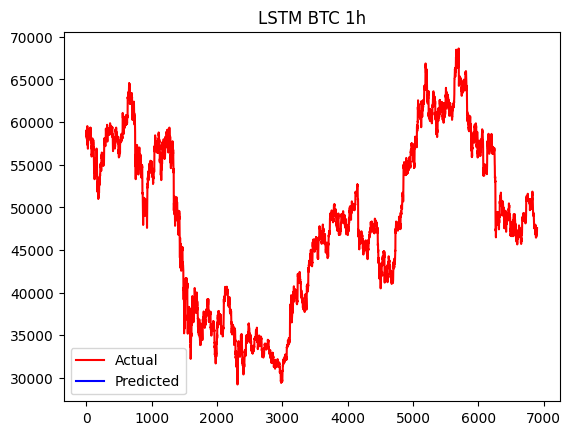

In [ ]:
plt.plot(y_test, color='red', label='Actual')
plt.plot(predicted, color='blue', label='Predicted')
plt.title('LSTM BTC 1h')
plt.legend() 